# Comparison of 5 CNN Models for Pneumonia Classification
## Comparative Analysis with Visualizations (Ensemble Results)

This notebook compares the performance of 5 different deep learning models:
1. **CNN Base** - VGG-like CNN trained from scratch
2. **VGG16** - Transfer learning with progressive fine-tuning
3. **ResNet50** - Transfer learning with skip connections
4. **EfficientNet-B0** - Feature extraction only
5. **DenseNet121** - Transfer learning with dense connections

All models use **ensemble predictions** (average of 3-fold CV models).

In [1]:
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
print('Libraries loaded!')

Libraries loaded!


## 1. Load Results from All Models

In [2]:
def load_model_result(filepath, model_name):
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        cv = data.get('cv', data.get('cv_results', {}))
        test = data.get('test_ensemble', data.get('test_results_ensemble', {}))
        return {
            'Model': model_name,
            'CV Accuracy': cv.get('accuracy_mean', 0),
            'CV AUC': cv.get('auc_mean', 0),
            'CV F1': cv.get('f1_mean', 0),
            'Test Accuracy': test.get('accuracy', 0),
            'Test AUC': test.get('auc', 0),
            'Test F1': test.get('f1', 0),
            'Test Sensitivity': test.get('sensitivity', test.get('recall', 0)),
            'Test Specificity': test.get('specificity', 0),
            'Test Precision': test.get('precision', 0),
            'Training Time (min)': data.get('total_time_min', data.get('total_training_time_minutes', 0))
        }
    except FileNotFoundError:
        print(f'WARNING: {filepath} not found!')
        return None

In [3]:
models = [
    ('model_1_cnn_ensemble_results.json', 'CNN Base'),
    ('model_2_vgg16_ensemble_results.json', 'VGG16'),
    ('model_3_resnet50_ensemble_results.json', 'ResNet50'),
    ('model_4_efficientnet_ensemble_results.json', 'EfficientNet-B0'),
    ('model_5_densenet121_ensemble_results.json', 'DenseNet121')
]
results = []
for filepath, name in models:
    result = load_model_result(filepath, name)
    if result:
        results.append(result)
        print(f'Loaded: {name}')
df = pd.DataFrame(results)
print(f'\nLoaded {len(df)} models')

Loaded: CNN Base
Loaded: VGG16
Loaded: ResNet50
Loaded: EfficientNet-B0
Loaded: DenseNet121

Loaded 5 models


In [4]:
print('\n' + '='*100)
print('MODEL COMPARISON SUMMARY (ENSEMBLE PREDICTIONS)')
print('='*100)
display_cols = ['Model', 'Test Accuracy', 'Test AUC', 'Test F1', 'Test Sensitivity', 'Test Specificity', 'Training Time (min)']
print(df[display_cols].to_string(index=False))
print('='*100)


MODEL COMPARISON SUMMARY (ENSEMBLE PREDICTIONS)
          Model  Test Accuracy  Test AUC  Test F1  Test Sensitivity  Test Specificity  Training Time (min)
       CNN Base       0.852564  0.949562 0.892523          0.979487          0.641026             6.497217
          VGG16       0.892628  0.976507 0.920143          0.989744          0.730769            13.697704
       ResNet50       0.919872  0.975707 0.938725          0.982051          0.816239            17.863418
EfficientNet-B0       0.886218  0.960322 0.913309          0.958974          0.764957             7.882183
    DenseNet121       0.900641  0.958361 0.920918          0.925641          0.858974            37.822427


## 2. Test Set Performance Comparison

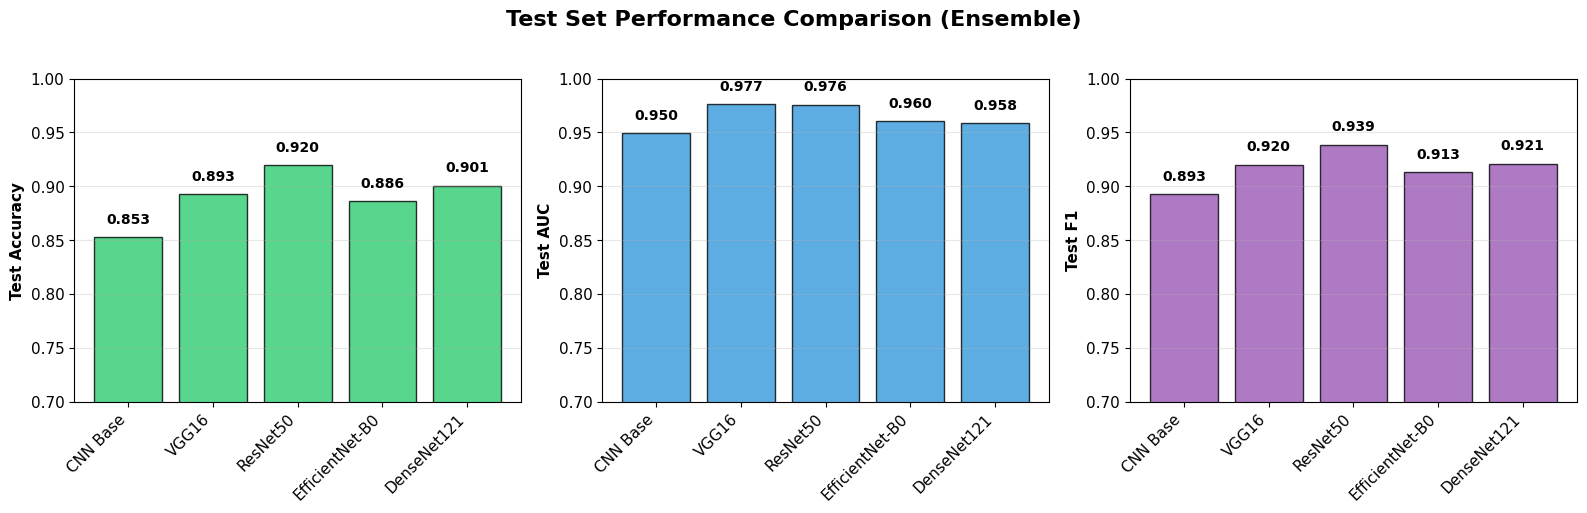

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['Test Accuracy', 'Test AUC', 'Test F1']
colors = ['#2ecc71', '#3498db', '#9b59b6']
for ax, metric, color in zip(axes, metrics, colors):
    values = df[metric].values
    x_pos = np.arange(len(df['Model']))
    bars = ax.bar(x_pos, values, color=color, edgecolor='black', alpha=0.8)
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_ylim(0.7, 1.0)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
plt.suptitle('Test Set Performance Comparison (Ensemble)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_test_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

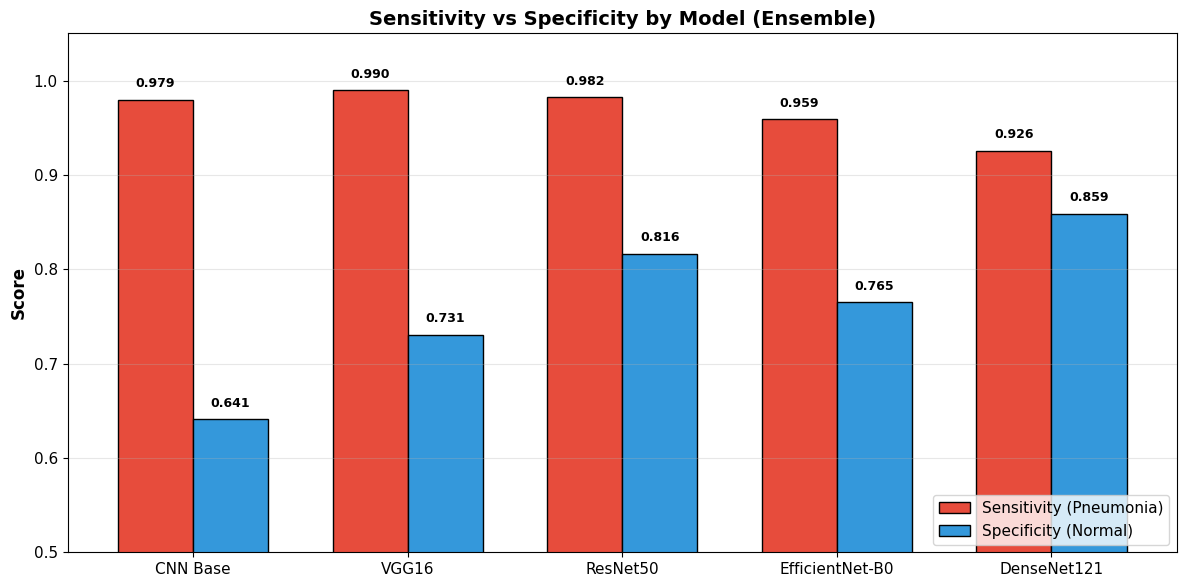

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(df['Model']))
bars1 = ax.bar(x - width/2, df['Test Sensitivity'], width, label='Sensitivity (Pneumonia)', color='#e74c3c', edgecolor='black')
bars2 = ax.bar(x + width/2, df['Test Specificity'], width, label='Specificity (Normal)', color='#3498db', edgecolor='black')
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Sensitivity vs Specificity by Model (Ensemble)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], fontsize=11)
ax.set_ylim(0.5, 1.05)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='y', alpha=0.3)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('comparison_sens_spec.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Radar Chart - Overall Performance

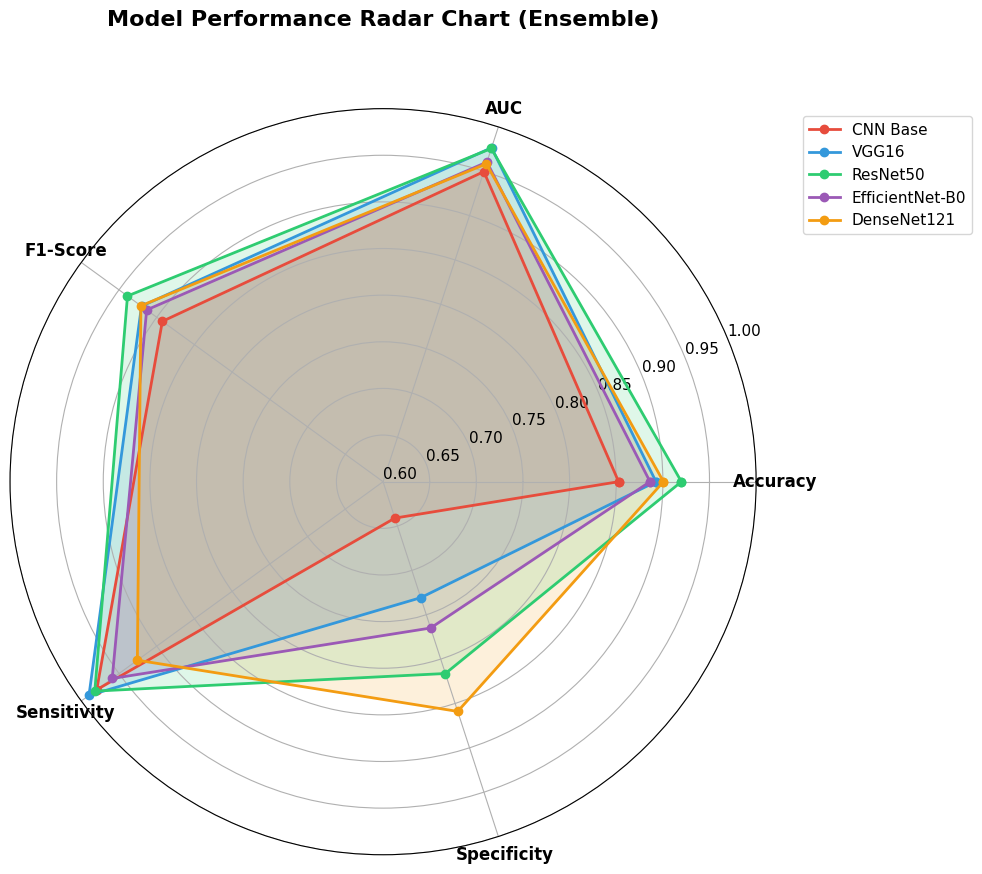

In [7]:
from math import pi
categories = ['Accuracy', 'AUC', 'F1-Score', 'Sensitivity', 'Specificity']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
for i, (_, row) in enumerate(df.iterrows()):
    values = [row['Test Accuracy'], row['Test AUC'], row['Test F1'], row['Test Sensitivity'], row['Test Specificity']]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_ylim(0.6, 1.0)
ax.set_title('Model Performance Radar Chart (Ensemble)', fontsize=16, fontweight='bold', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
plt.tight_layout()
plt.savefig('comparison_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Training Time Comparison

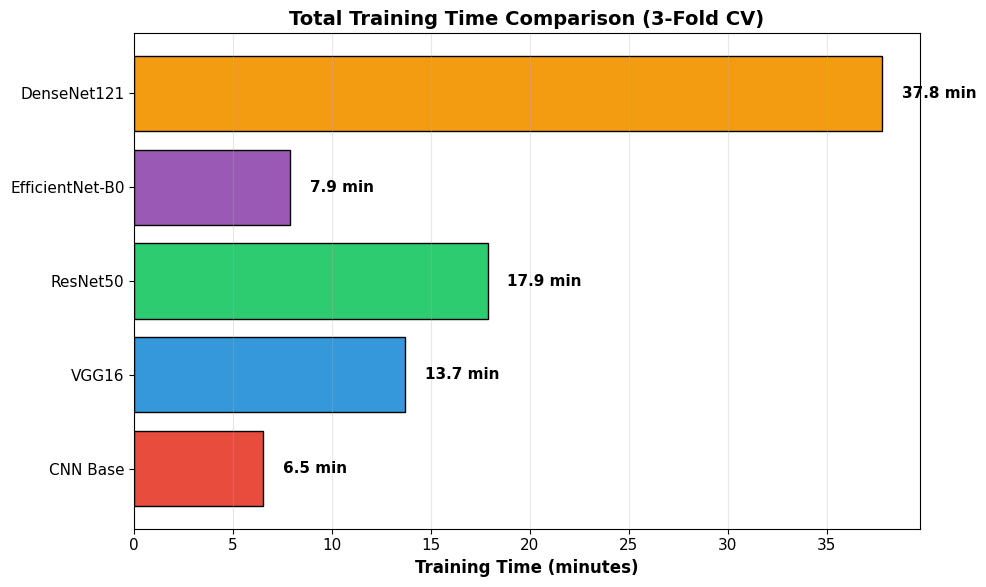

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
bars = ax.barh(df['Model'], df['Training Time (min)'], color=colors, edgecolor='black')
ax.set_xlabel('Training Time (minutes)', fontweight='bold', fontsize=12)
ax.set_title('Total Training Time Comparison (3-Fold CV)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, df['Training Time (min)']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f} min', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('comparison_training_time.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Heatmap - All Metrics

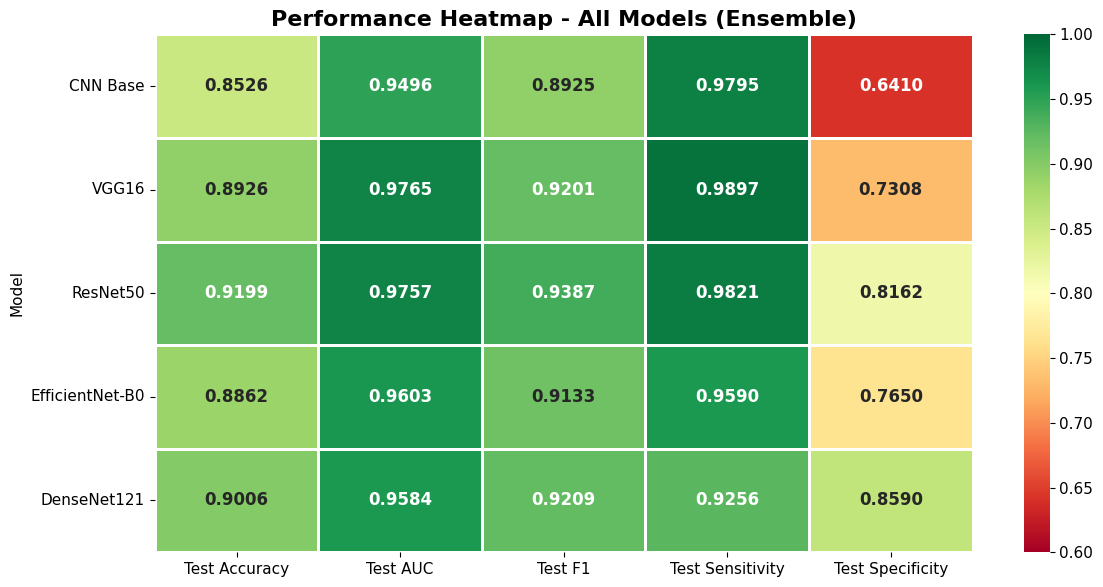

In [9]:
metrics_cols = ['Test Accuracy', 'Test AUC', 'Test F1', 'Test Sensitivity', 'Test Specificity']
heatmap_data = df[metrics_cols].copy()
heatmap_data.index = df['Model']
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', linewidths=2, linecolor='white', vmin=0.6, vmax=1.0, annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Performance Heatmap - All Models (Ensemble)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('comparison_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Courbes ROC Comparatives - Tous les Modeles

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

IMG_SIZE, BATCH_SIZE = 128, 32
CLASS_MAP = {'NORMAL': 0, 'PNEUMONIA': 1}

def load_test_data():
    paths, labels = [], []
    for cn in ['NORMAL', 'PNEUMONIA']:
        cd = Path('chest_xray/test') / cn
        for p in cd.glob('*'):
            if p.suffix.lower() in ['.jpeg','.jpg','.png']:
                paths.append(str(p)); labels.append(CLASS_MAP[cn])
    return np.array(paths), np.array(labels)

test_paths, y_true = load_test_data()
print(f'Test: {len(y_true)} images (Normal: {sum(y_true==0)}, Pneumonia: {sum(y_true==1)})')

Test: 624 images (Normal: 234, Pneumonia: 390)


In [11]:
# Dataset creation functions for each preprocessing type
def create_dataset_simple(paths, labels):  # CNN Base, VGG16, DenseNet121 use /255
    def load_img(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return tf.cast(img, tf.float32) / 255.0, l
    return tf.data.Dataset.from_tensor_slices((paths, labels)).map(load_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def create_dataset_resnet(paths, labels):  # ResNet50 uses resnet preprocess_input
    def load_img(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return resnet_preprocess(img), l
    return tf.data.Dataset.from_tensor_slices((paths, labels)).map(load_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def create_dataset_effnet(paths, labels):  # EfficientNet uses effnet preprocess_input
    def load_img(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return effnet_preprocess(tf.cast(img, tf.float32)), l
    return tf.data.Dataset.from_tensor_slices((paths, labels)).map(load_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# EfficientNet architecture (exactly as original)
def create_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    base.trainable = False
    inp = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return keras.Model(inp, out)

print('Dataset functions defined.')

Dataset functions defined.


In [12]:
model_configs = [
    {'name': 'CNN Base', 'files': ['model_1_cnn_fold_1.keras', 'model_1_cnn_fold_2.keras', 'model_1_cnn_fold_3.keras'], 'color': '#e74c3c', 'type': 'keras', 'ds': 'simple'},
    {'name': 'VGG16', 'files': ['model_2_vgg16_fold_1.keras', 'model_2_vgg16_fold_2.keras', 'model_2_vgg16_fold_3.keras'], 'color': '#3498db', 'type': 'keras', 'ds': 'simple'},
    {'name': 'ResNet50', 'files': ['model_3_resnet50_fold_1.keras', 'model_3_resnet50_fold_2.keras', 'model_3_resnet50_fold_3.keras'], 'color': '#2ecc71', 'type': 'keras', 'ds': 'resnet'},
    {'name': 'EfficientNet-B0', 'files': ['model_4_efficientnet_fold_1_weights.h5', 'model_4_efficientnet_fold_2_weights.h5', 'model_4_efficientnet_fold_3_weights.h5'], 'color': '#9b59b6', 'type': 'effnet', 'ds': 'effnet'},
    {'name': 'DenseNet121', 'files': ['model_5_densenet121_fold_1.keras', 'model_5_densenet121_fold_2.keras', 'model_5_densenet121_fold_3.keras'], 'color': '#f39c12', 'type': 'keras', 'ds': 'simple'}
]

# Create datasets once for each preprocessing type
ds_simple = create_dataset_simple(test_paths, y_true)
ds_resnet = create_dataset_resnet(test_paths, y_true)
ds_effnet = create_dataset_effnet(test_paths, y_true)

roc_data = {}
for config in model_configs:
    print(f"\n{'='*50}\n{config['name']}")
    fold_preds = []
    
    # Select correct dataset
    if config['ds'] == 'resnet':
        ds = ds_resnet
    elif config['ds'] == 'effnet':
        ds = ds_effnet
    else:
        ds = ds_simple
    
    for fold_file in config['files']:
        if not os.path.exists(fold_file): print(f"  Missing: {fold_file}"); continue
        try:
            tf.keras.backend.clear_session()
            if config['type'] == 'effnet':
                model = create_efficientnet()
                model.load_weights(fold_file)
            else:
                model = keras.models.load_model(fold_file)
            preds = model.predict(ds, verbose=0).flatten()
            fold_preds.append(preds)
            print(f"  Loaded: {fold_file}")
        except Exception as e:
            print(f"  ERROR: {e}")
    
    if fold_preds:
        y_pred = np.mean(fold_preds, axis=0)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        if roc_auc < 0.5:
            print(f"  Inverting predictions (AUC was {roc_auc:.4f})")
            y_pred = 1 - y_pred
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
        roc_data[config['name']] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc, 'color': config['color']}
        print(f"  AUC: {roc_auc:.4f}")

print(f"\nLoaded {len(roc_data)} models for ROC")


CNN Base
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
  Loaded: model_1_cnn_fold_1.keras
  Loaded: model_1_cnn_fold_2.keras
  Loaded: model_1_cnn_fold_3.keras
  AUC: 0.9496

VGG16
  Loaded: model_2_vgg16_fold_1.keras
  Loaded: model_2_vgg16_fold_2.keras
  Loaded: model_2_vgg16_fold_3.keras
  AUC: 0.9195

ResNet50
  Loaded: model_3_resnet50_fold_1.keras
  Loaded: model_3_resnet50_fold_2.keras
  Loaded: model_3_resnet50_fold_3.keras
  AUC: 0.9757

EfficientNet-B0
  Loaded: model_4_efficientnet_fold_1_weights.h5
  Loaded: model_4_efficientnet_fold_2_weights.h5
  Loaded: model_4_efficientnet_fold_3_weights.h5
  AUC: 0.9603

DenseNet121
  Loaded: model_5_densenet121_fold_1.keras
  Loaded: model_5_densenet121_fold_2.keras
  Loaded: model_5_densenet121_fold_3.keras
  AUC: 0.9523

Loade

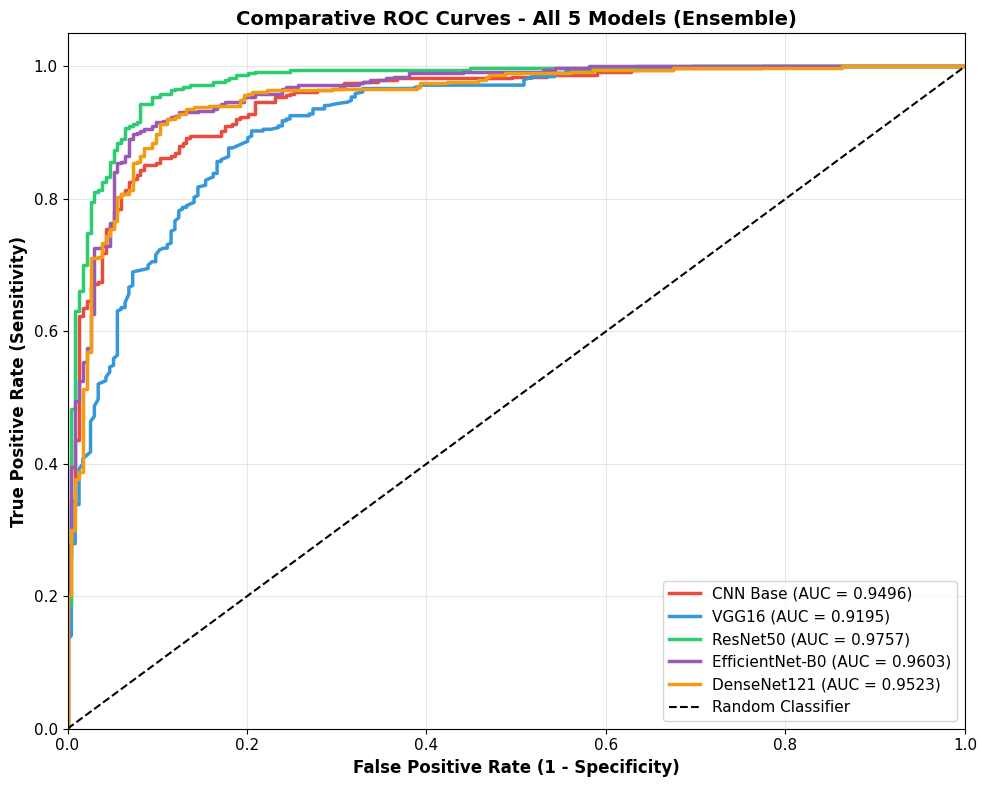

ROC curves saved: comparison_roc_curves.png


In [13]:
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], color=data['color'], linewidth=2.5, label=f"{name} (AUC = {data['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
plt.title('Comparative ROC Curves - All 5 Models (Ensemble)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('ROC curves saved: comparison_roc_curves.png')

## 7. CV vs Test Performance

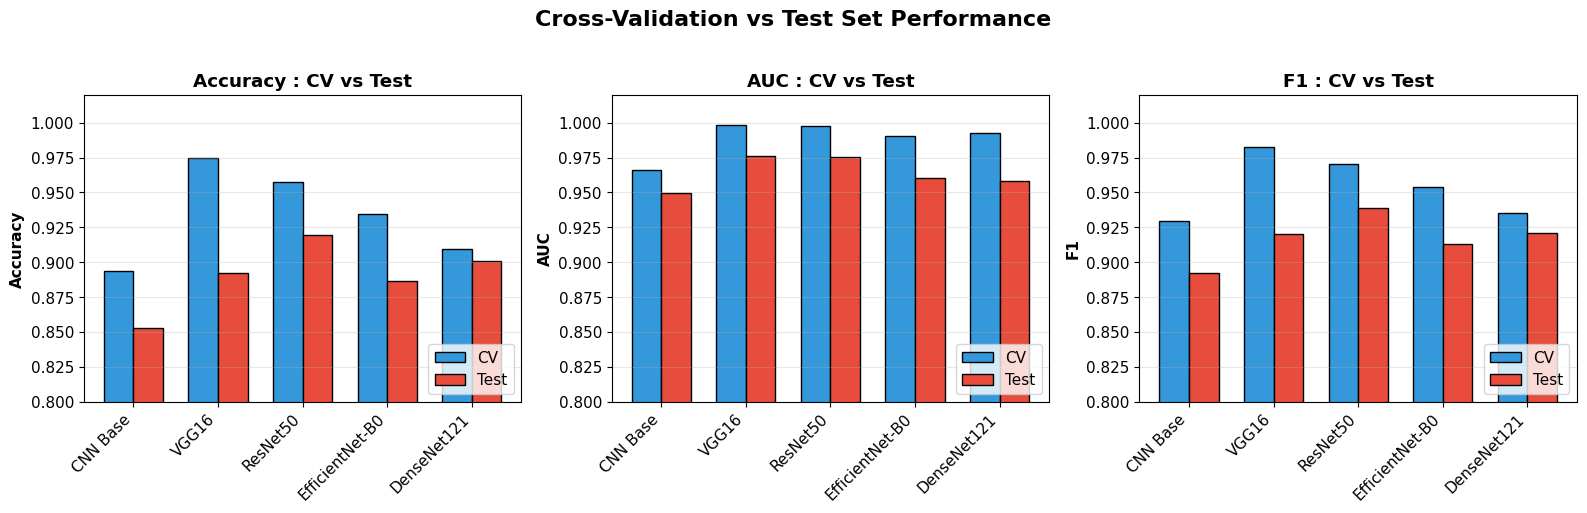

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics_pairs = [('CV Accuracy', 'Test Accuracy'), ('CV AUC', 'Test AUC'), ('CV F1', 'Test F1')]
for ax, (cv_m, test_m) in zip(axes, metrics_pairs):
    x = np.arange(len(df))
    width = 0.35
    ax.bar(x - width/2, df[cv_m], width, label='CV', color='#3498db', edgecolor='black')
    ax.bar(x + width/2, df[test_m], width, label='Test', color='#e74c3c', edgecolor='black')
    ax.set_ylabel(cv_m.replace('CV ', ''), fontweight='bold')
    ax.set_title(f'{cv_m.replace("CV ", "")} : CV vs Test', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.set_ylim(0.8, 1.02)
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
plt.suptitle('Cross-Validation vs Test Set Performance', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_cv_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Best Model Analysis

In [15]:
print('\n' + '='*70)
print('BEST MODEL FOR EACH METRIC')
print('='*70)
metrics_to_check = {'Test Accuracy': 'max', 'Test AUC': 'max', 'Test F1': 'max', 'Test Sensitivity': 'max', 'Test Specificity': 'max', 'Training Time (min)': 'min'}
for metric, op in metrics_to_check.items():
    idx = df[metric].idxmin() if op == 'min' else df[metric].idxmax()
    print(f"{metric:25} : {df.loc[idx, 'Model']:15} ({df.loc[idx, metric]:.4f})")
print('='*70)


BEST MODEL FOR EACH METRIC
Test Accuracy             : ResNet50        (0.9199)
Test AUC                  : VGG16           (0.9765)
Test F1                   : ResNet50        (0.9387)
Test Sensitivity          : VGG16           (0.9897)
Test Specificity          : DenseNet121     (0.8590)
Training Time (min)       : CNN Base        (6.4972)


In [16]:
print('\n' + '='*70)
print('OVERALL RANKING (Weighted Score)')
print('='*70)
print('Weights: AUC=0.25, F1=0.25, Sensitivity=0.30, Specificity=0.20')
df['Weighted Score'] = 0.25*df['Test AUC'] + 0.25*df['Test F1'] + 0.30*df['Test Sensitivity'] + 0.20*df['Test Specificity']
df_ranked = df.sort_values('Weighted Score', ascending=False).reset_index(drop=True)
df_ranked['Rank'] = range(1, len(df_ranked)+1)
for _, row in df_ranked.iterrows():
    print(f"{row['Rank']}. {row['Model']:20} - Weighted Score: {row['Weighted Score']:.4f}")
print('='*70)
print(f"\n>>> BEST OVERALL MODEL: {df_ranked.iloc[0]['Model']} <<<")
print(f">>> Weighted Score: {df_ranked.iloc[0]['Weighted Score']:.4f} <<<")
print('='*70)


OVERALL RANKING (Weighted Score)
Weights: AUC=0.25, F1=0.25, Sensitivity=0.30, Specificity=0.20
1. ResNet50             - Weighted Score: 0.9365
2. DenseNet121          - Weighted Score: 0.9193
3. VGG16                - Weighted Score: 0.9172
4. EfficientNet-B0      - Weighted Score: 0.9091
5. CNN Base             - Weighted Score: 0.8826

>>> BEST OVERALL MODEL: ResNet50 <<<
>>> Weighted Score: 0.9365 <<<


## 9. Final Summary

In [17]:
print('\n' + '='*100)
print('FINAL SUMMARY TABLE (ENSEMBLE PREDICTIONS)')
print('='*100)
summary_df = df_ranked[['Rank', 'Model', 'Test Accuracy', 'Test AUC', 'Test F1', 'Test Sensitivity', 'Test Specificity', 'Training Time (min)', 'Weighted Score']].copy()
for col in summary_df.columns:
    if col not in ['Model', 'Rank']:
        summary_df[col] = summary_df[col].round(4)
print(summary_df.to_string(index=False))
print('='*100)


FINAL SUMMARY TABLE (ENSEMBLE PREDICTIONS)
 Rank           Model  Test Accuracy  Test AUC  Test F1  Test Sensitivity  Test Specificity  Training Time (min)  Weighted Score
    1        ResNet50         0.9199    0.9757   0.9387            0.9821            0.8162              17.8634          0.9365
    2     DenseNet121         0.9006    0.9584   0.9209            0.9256            0.8590              37.8224          0.9193
    3           VGG16         0.8926    0.9765   0.9201            0.9897            0.7308              13.6977          0.9172
    4 EfficientNet-B0         0.8862    0.9603   0.9133            0.9590            0.7650               7.8822          0.9091
    5        CNN Base         0.8526    0.9496   0.8925            0.9795            0.6410               6.4972          0.8826


In [18]:
comparison_output = {
    'ranking': df_ranked[['Rank', 'Model', 'Weighted Score']].to_dict('records'),
    'best_model': df_ranked.iloc[0]['Model'],
    'best_score': float(df_ranked.iloc[0]['Weighted Score'])
}
with open('models_comparison_ensemble_final.json', 'w') as f:
    json.dump(comparison_output, f, indent=2)
print('Saved: models_comparison_ensemble_final.json')

Saved: models_comparison_ensemble_final.json


## 10. Strengths & Weaknesses Table

In [19]:
from IPython.display import display, HTML

def get_val(model, metric):
    row = df[df['Model'] == model]
    return row[metric].values[0] if len(row) > 0 else 0

data_sw = {
    'Modele': ['CNN Base', 'VGG16', 'ResNet50', 'EfficientNet-B0', 'DenseNet121'],
    'Forces': [
        f"Simple, rapide ({get_val('CNN Base', 'Training Time (min)'):.1f} min)",
        f"Sensibilite elevee ({get_val('VGG16', 'Test Sensitivity')*100:.1f}%)",
        f"Meilleur equilibre, Accuracy ({get_val('ResNet50', 'Test Accuracy')*100:.1f}%)",
        f"Architecture efficiente, AUC ({get_val('EfficientNet-B0', 'Test AUC'):.4f})",
        f"Dense connections, Specificite ({get_val('DenseNet121', 'Test Specificity')*100:.1f}%)"
    ],
    'Faiblesses': [
        f"Specificite faible ({get_val('CNN Base', 'Test Specificity')*100:.1f}%)",
        f"Specificite moderee ({get_val('VGG16', 'Test Specificity')*100:.1f}%)",
        f"Modele volumineux, Specificite ({get_val('ResNet50', 'Test Specificity')*100:.1f}%)",
        f"Sensibilite moderee ({get_val('EfficientNet-B0', 'Test Sensitivity')*100:.1f}%)",
        f"Temps long ({get_val('DenseNet121', 'Training Time (min)'):.1f} min)"
    ],
    'Usage': ['Prototypage', 'Screening', 'Diagnostic', 'Deploiement leger', 'Recherche'],
    'Score': [get_val(m, 'Weighted Score') if 'Weighted Score' in df.columns else 0 for m in ['CNN Base', 'VGG16', 'ResNet50', 'EfficientNet-B0', 'DenseNet121']]
}
df_sw = pd.DataFrame(data_sw)
best_model = df_ranked.iloc[0]['Model']
second_model = df_ranked.iloc[1]['Model']

html = '<style>.tbl{border-collapse:collapse;width:100%;font-size:14px;color:#000}.tbl th{background:#2c3e50;color:white;padding:12px}.tbl td{padding:12px;border:1px solid #ddd}.tbl tr:nth-child(even){background:#f8f9fa}.best{background:#d4edda!important;border-left:4px solid #1e7e34}.second{background:#fff3cd!important;border-left:4px solid #c69500}</style><table class="tbl"><tr><th>Modele</th><th>Forces</th><th>Faiblesses</th><th>Usage</th><th>Score</th></tr>'
for i, row in df_sw.iterrows():
    cls = 'best' if row['Modele'] == best_model else ('second' if row['Modele'] == second_model else '')
    html += f'<tr class="{cls}"><td><b>{row["Modele"]}</b></td><td>{row["Forces"]}</td><td>{row["Faiblesses"]}</td><td>{row["Usage"]}</td><td><b>{row["Score"]:.4f}</b></td></tr>'
html += '</table>'
display(HTML(html))

Modele,Forces,Faiblesses,Usage,Score
CNN Base,"Simple, rapide (6.5 min)",Specificite faible (64.1%),Prototypage,0.8826
VGG16,Sensibilite elevee (99.0%),Specificite moderee (73.1%),Screening,0.9172
ResNet50,"Meilleur equilibre, Accuracy (92.0%)","Modele volumineux, Specificite (81.6%)",Diagnostic,0.9365
EfficientNet-B0,"Architecture efficiente, AUC (0.9603)",Sensibilite moderee (95.9%),Deploiement leger,0.9091
DenseNet121,"Dense connections, Specificite (85.9%)",Temps long (37.8 min),Recherche,0.9193


## 11. Matrices de Confusion Globales

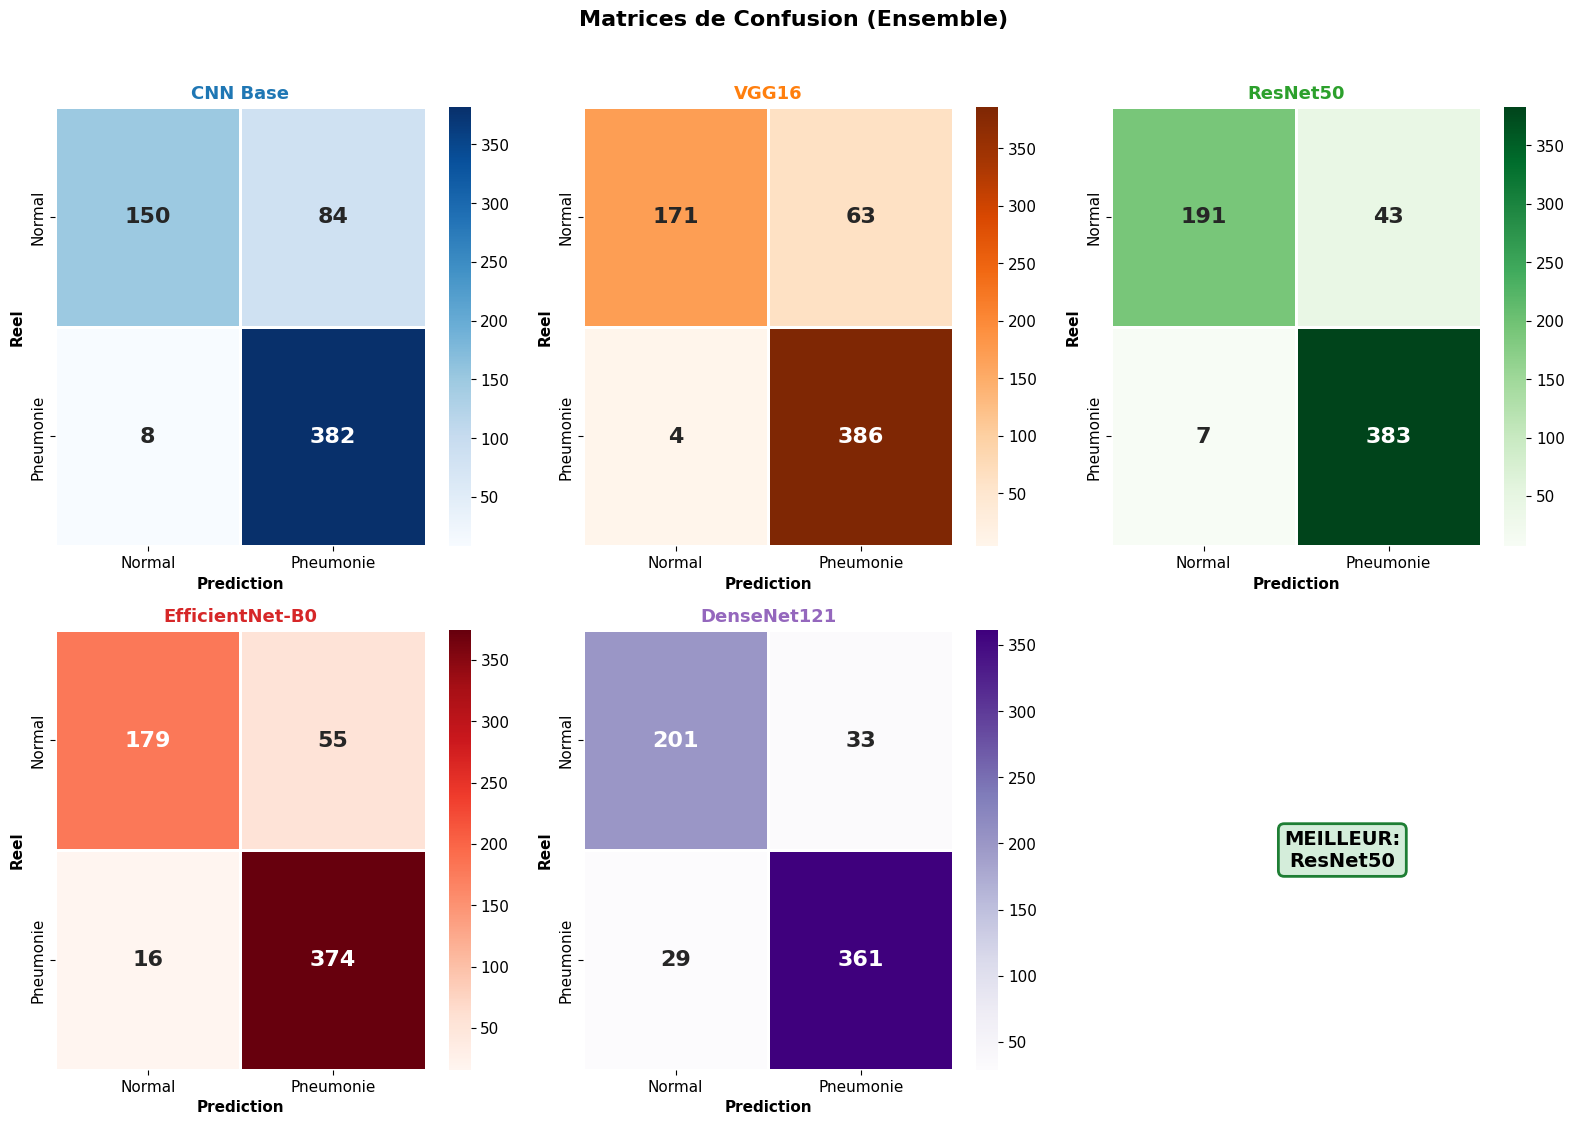

In [20]:
test_normal, test_pneumonia = 234, 390
models_cm = {row['Model']: {'sensitivity': row['Test Sensitivity'], 'specificity': row['Test Specificity']} for _, row in df.iterrows()}
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()
for idx, (model, metrics) in enumerate(models_cm.items()):
    TP = int(test_pneumonia * metrics['sensitivity'])
    TN = int(test_normal * metrics['specificity'])
    cm = np.array([[TN, test_normal-TN], [test_pneumonia-TP, TP]])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes[idx], xticklabels=['Normal', 'Pneumonie'], yticklabels=['Normal', 'Pneumonie'], annot_kws={'size': 16, 'weight': 'bold'}, linewidths=2)
    axes[idx].set_xlabel('Prediction', fontweight='bold')
    axes[idx].set_ylabel('Reel', fontweight='bold')
    axes[idx].set_title(model, fontsize=13, fontweight='bold', color=colors[idx])
axes[5].axis('off')
axes[5].text(0.5, 0.5, f'MEILLEUR:\n{df_ranked.iloc[0]["Model"]}', ha='center', va='center', fontsize=14, fontweight='bold', bbox=dict(boxstyle='round', facecolor='#d4edda', edgecolor='#1e7e34', linewidth=2), transform=axes[5].transAxes)
plt.suptitle('Matrices de Confusion (Ensemble)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('global_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Analyse Textuelle

In [21]:
from IPython.display import display, Markdown
best = df_ranked.iloc[0]
second = df_ranked.iloc[1]
analysis = f'''# POURQUOI {best['Model'].upper()} GAGNE ?\n\n| Rang | Modele | Score |\n|------|--------|-------|\n'''
for _, row in df_ranked.iterrows():
    bold = '**' if row['Rank'] == 1 else ''
    analysis += f"| {bold}{row['Rank']}{bold} | {bold}{row['Model']}{bold} | {bold}{row['Weighted Score']:.4f}{bold} |\n"
analysis += f'''\n## Metriques Cles de {best['Model']}\n- **Accuracy**: {best['Test Accuracy']*100:.2f}%\n- **AUC**: {best['Test AUC']:.4f}\n- **F1**: {best['Test F1']*100:.2f}%\n- **Sensibilite**: {best['Test Sensitivity']*100:.2f}%\n- **Specificite**: {best['Test Specificity']*100:.2f}%\n\n## Conclusion\n**{best['Model']}** offre le meilleur equilibre entre detection des pneumonies et reduction des faux positifs.'''
display(Markdown(analysis))

# POURQUOI RESNET50 GAGNE ?

| Rang | Modele | Score |
|------|--------|-------|
| **1** | **ResNet50** | **0.9365** |
| 2 | DenseNet121 | 0.9193 |
| 3 | VGG16 | 0.9172 |
| 4 | EfficientNet-B0 | 0.9091 |
| 5 | CNN Base | 0.8826 |

## Metriques Cles de ResNet50
- **Accuracy**: 91.99%
- **AUC**: 0.9757
- **F1**: 93.87%
- **Sensibilite**: 98.21%
- **Specificite**: 81.62%

## Conclusion
**ResNet50** offre le meilleur equilibre entre detection des pneumonies et reduction des faux positifs.

## 13. Recapitulatif Final

In [22]:
best_sens = df.loc[df['Test Sensitivity'].idxmax()]
best_spec = df.loc[df['Test Specificity'].idxmax()]
best_time = df.loc[df['Training Time (min)'].idxmin()]
print('='*80)
print('CHOIX DU MODELE SELON L\'OBJECTIF')
print('='*80)
print(f'''\n| Objectif             | Modele recommande                              |\n|----------------------|------------------------------------------------|\n| Diagnostic clinique  | {df_ranked.iloc[0]['Model']} - meilleur equilibre         |\n| Screening massif     | {best_sens['Model']} - sensibilite max ({best_sens['Test Sensitivity']*100:.1f}%)       |\n| Eviter faux positifs | {best_spec['Model']} - specificite max ({best_spec['Test Specificity']*100:.1f}%)  |\n| Prototypage rapide   | {best_time['Model']} - plus rapide ({best_time['Training Time (min)']:.1f} min)        |\n''')
print('Legende: Vert = meilleur, Jaune = second')
print('='*80)
print('\nCOMPARISON COMPLETE!')

CHOIX DU MODELE SELON L'OBJECTIF

| Objectif             | Modele recommande                              |
|----------------------|------------------------------------------------|
| Diagnostic clinique  | ResNet50 - meilleur equilibre         |
| Screening massif     | VGG16 - sensibilite max (99.0%)       |
| Eviter faux positifs | DenseNet121 - specificite max (85.9%)  |
| Prototypage rapide   | CNN Base - plus rapide (6.5 min)        |

Legende: Vert = meilleur, Jaune = second

COMPARISON COMPLETE!


In [23]:
print('\nFigures generees:')
for f in ['comparison_test_metrics', 'comparison_sens_spec', 'comparison_radar_chart', 'comparison_training_time', 'comparison_heatmap', 'comparison_roc_curves', 'comparison_cv_vs_test', 'global_confusion_matrices']:
    print(f'  - {f}.png')


Figures generees:
  - comparison_test_metrics.png
  - comparison_sens_spec.png
  - comparison_radar_chart.png
  - comparison_training_time.png
  - comparison_heatmap.png
  - comparison_roc_curves.png
  - comparison_cv_vs_test.png
  - global_confusion_matrices.png
